# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first, merge

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [9]:
decoys = tmol.tests.data.structures_bysize()

In [24]:
from itertools import product

import tmol.score.ljlk.numba_potential

def benchmark_decoys(decoys, cpu=True, cuda=True):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        ibd = score_graph.interblock_distance.min_dist[0]
        
        
        cpu_scores = {}
        
        for parallel, blocked in product((True, False), (True, False)):
            n = ".cpu" + ("_parallel" if parallel else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords,
                    types,
                    path_length,

                    ljlk_resolver.pair_params.lj_sigma,
                    ljlk_resolver.pair_params.lj_switch_slope,
                    ljlk_resolver.pair_params.lj_switch_intercept,
                    ljlk_resolver.pair_params.lj_coeff_sigma12,
                    ljlk_resolver.pair_params.lj_coeff_sigma6,
                    ljlk_resolver.pair_params.lj_spline_y0,
                    ljlk_resolver.pair_params.lj_spline_dy0,

                    ljlk_resolver.global_params.lj_switch_dis2sigma,
                    ljlk_resolver.global_params.spline_start,
                    ljlk_resolver.global_params.max_dis,
                    parallel=parallel,
                    block_distances=ibd if blocked else None
                ).sum()
            cpu_scores[n] = score
            
        logging.info(f"cpu: {cpu_scores}")
         
        continue
        
        score_graph_c = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system, device=torch.device("cuda"))
        ljlk_resolver_c = score_graph_c.param_resolver
        coords_c = score_graph_c.coords.detach()[0]
        types_c = types.cuda()
        path_length_c = path_length.cuda()
        ibd_c = score_graph_c.interblock_distance.min_dist[0]
                
        inputs = dict(
            atom_types = types_c,
            bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
         lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
         lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
         lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
         lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
         lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
         lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
         lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
            
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        
        
        @subfixture(fixture, platform="cuda")
        def cuda():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(inputs, params)
                ).sum()
            finally:
                torch.cuda.synchronize()
        
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_params():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
                
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_all():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(preorg_inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
            
        logging.info(f"cpu_serial: {cpu_serial} cpu_parallel: {cpu_parallel} cuda: {cuda} cuda_preorg_all: {cuda_preorg_all}")
        
    return stats

In [25]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-84.5055), '.cpu_parallel': tensor(-84.5055), '.cpu_blocked': tensor(-84.5055), '.cpu': tensor(-84.5055)}
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-9.2401), '.cpu_parallel': tensor(-9.2401), '.cpu_blocked': tensor(-9.2401), '.cpu': tensor(-9.2401)}
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-154.1009), '.cpu_parallel': tensor(-154.1009), '.cpu_blocked': tensor(-154.1009), '.cpu': tensor(-154.1009)}
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-214.8056), '.cpu_parallel': tensor(-214.8056), '.cpu_blocked': tensor(-214.8056), '.cpu': tensor(-214.8056)}
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-78.0165), '.cpu_parallel': tensor(-78.0165), '.cpu_blocked': tensor(-78.0165), '.cpu': tensor(-78.0165)}
INFO:root:BYSIZE_055_RES_2JWU
INFO:root:cpu: {'.cpu_parallel_blocked': tenso

In [28]:
import pandas
import seaborn
from matplotlib import pyplot

In [29]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

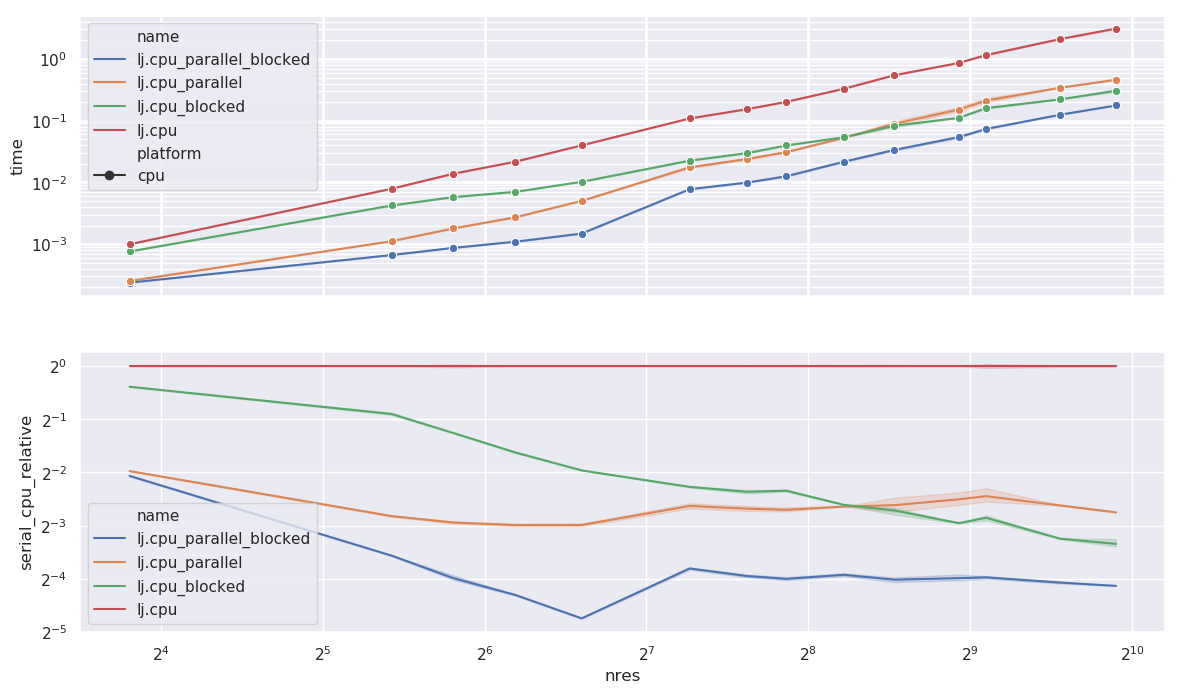

In [30]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [21]:
(
    dat.query("name=='lj.cuda_preorg_all'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

TypeError: reorder_levels() got an unexpected keyword argument 'axis'